<h1 style="text-align: center;">Deep Learning Image Classification with CNN<br><br>Cat-Dog Classification Project<br><h1>

# Dataset Info

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

You will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set includes 6897 cat and dogs images together. 

- https://www.kaggle.com/c/dogs-vs-cats/data
- https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

# Import Libraries and Export Images from Zip_File

## colab Package Update

⚠️ **need to restart**

- https://github.com/tensorflow/addons#python-op-compatibility-matrix

In [1]:
# !pip install -Uq scikeras[tensorflow] # Causes tensorflow to update.
!pip install -Uq matplotlib matplotlib-dashboard seaborn scikit-plot tensorflow-addons==0.16.1  # tensorflow-addons -> colab-0.19.0, Kaggle-0.16.1

## Import Libraries

### Colab-only auth for this notebook and the TPU

In [2]:
import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    from google.colab import auth
    # Authenticates the Colab machine and also the TPU using your
    # credentials so that they can access your private GCS buckets.
    auth.authenticate_user()

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### TPU or GPU detection

In [5]:
import tensorflow as tf

print("Tensorflow version \t\t:" + tf.__version__)

# print("Available devices:")
# for i, device in enumerate(tf.config.list_logical_devices()):
#     print("%d) %s" % (i, device))

# check if tensorflow see the GPU
# tf.test.gpu_device_name()

print("Num physical_GPUs Available\t:", len(tf.config.list_physical_devices('GPU')))
print("Num physical_CPUs Available\t:", len(tf.config.list_physical_devices('CPU')))
print()
print("Num logical_GPUs Available\t:", len(tf.config.list_logical_devices('GPU')))
print("Num logical_CPUs Available\t:", len(tf.config.list_logical_devices('CPU')))

Tensorflow version 		:2.6.4
Num physical_GPUs Available	: 2
Num physical_CPUs Available	: 1

Num logical_GPUs Available	: 2
Num logical_CPUs Available	: 1


2023-01-08 21:39:41.943917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 21:39:41.944817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 21:39:42.069658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 21:39:42.070600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 21:39:42.071461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
import tensorflow as tf

try:
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # tf.config.experimental_connect_to_cluster(resolver)
    # tf.tpu.experimental.initialize_tpu_system(resolver)
    # strategy = tf.distribute.TPUStrategy(resolver)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)    
    print('Running on TPU ', tpu.master(), len(tf.config.list_logical_devices('TPU')))
    
except ValueError:
    # If there's a GPU avaiable, to use the GPU, otherwise, using the CPU instead.
    gpus = tf.config.list_logical_devices('GPU')
    if len(gpus) > 1:        
        strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])           
        print('Running on multiple GPUs ', gpus)  
    elif len(gpus) == 1:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on single GPU ', gpus[0].name)
    else:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on CPU')
        
print("Number of accelerators: ", strategy.num_replicas_in_sync)    
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

Running on multiple GPUs  [LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]
Number of accelerators:  2


In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
# The style parameters control properties like the color of the background and whether a grid is enabled by default.
# sns.set_style("whitegrid")
sns.set_style("whitegrid", {'axes.grid' : False})

# Environment settings: 
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# pd.options.display.float_format = '{:.4f}'.format
# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', 100)

In [8]:
import logging
logging.warning('this will not show!')
logging.basicConfig()  # configures the root logger
logging.captureWarnings(True)
logging.getLogger("py.warnings").setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.warn("logged: this will not show")

with warnings.catch_warnings():
    warnings.warn('also logged')

with warnings.catch_warnings(record=True) as warnings_caught:
    warnings.warn('not logged')

# show warnings recorded
print([w.message for w in warnings_caught])

[]


In [9]:
import re
import random
import pathlib

from glob import glob
from matplotlib.image import imread
import scipy.stats as stats

### Parameters

In [10]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

seed = random_state = 101

print(BATCH_SIZE)
print(round(LEARNING_RATE*LEARNING_RATE_EXP_DECAY, 3))

128
0.007


## Ingest Data from links below

In [11]:
# # https://github.com/wkentaro/gdown
!pip install gdown -Uq
import gdown

# Data Source
# url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

# private Data Source
url = 'https://drive.google.com/u/0/uc?id=1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h&export=download'
id  = '1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h'

output = 'cat_dog_data.zip'                          # download local colab etc.
# output = '/content/drive/MyDrive/cat_dog_data.zip' # download drive
gdown.download(url=url, output=output, quiet=False)

!unzip -oq $output # unzip from $output to local

Downloading...
From: https://drive.google.com/u/0/uc?id=1tP_J6JW2CHroJPyFqSE2kgs3bRcVCy3h&export=download
To: /kaggle/working/cat_dog_data.zip
100%|██████████| 595M/595M [00:02<00:00, 218MB/s]  


In [12]:
# !unzip -oq /content/drive/MyDrive/yy-Data-Sources/cat_dog_data.zip

In [13]:
# Alternative method linux bash command
!sudo apt-get -qq install tree 
!tree -d ./data

./data
├── test
├── train
│   ├── cat
│   └── dog
└── validation
    ├── cat
    └── dog

7 directories


# Recognizing and Understanding Data

In [14]:
data_dir = "./data"

train_path = data_dir+'/train'
val_path   = data_dir+'/validation'
test_path  = data_dir+'/test'

print(train_path, val_path, test_path, sep='\n')

./data/train
./data/validation
./data/test


**Let's check how many images there are.**

In [15]:
from glob import glob

train_file_paths = glob(train_path + '/*/*.jpg')
total_train_file = len(train_file_paths)

val_file_paths   = glob(val_path + '/*/*.jpg')
total_val_file   = len(val_file_paths)

test_file_paths  = glob(test_path + '/*.jpg')
total_test_file   = len(test_file_paths)

print(f'Train size\t: {total_train_file:<10}')
print(f'Val size\t: {total_val_file:<10}')
print(f'Test size\t: {total_test_file:<10}')

Train size	: 17526     
Val size	: 2290      
Test size	: 6897      


# Data Preprocessing

## Define Parameters

**Let's decide on the final dimension of these images.**

In [16]:
CLASS_NAMES = np.unique(os.listdir(train_path))
CLASS_NAMES

array(['cat', 'dog'], dtype='<U3')

In [17]:
print(mpl.image.imread(train_file_paths[0]).shape)
IMAGE_SHAPE = (350, 400, 3)
IMAGE_SHAPE

(304, 499, 3)


(350, 400, 3)

## Check Scalling

**Let's check the images if they are needed to be scaled or not**

- https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

In [18]:
mpl.image.imread(train_file_paths[0]).min(), mpl.image.imread(train_file_paths[0]).max()

(0, 255)

# Convolutional Neural Network Modeling

In [19]:
# !pip install tensorflow -Uq
import tensorflow as tf
# !pip install tensorflow-addons -Uq
import tensorflow_addons as tfa

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve #, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  SCORERS, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

# !pip install scikeras[tensorflow] -Uq  # Causes tensorflow to update.
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [20]:
# !pip install scikit-plot -Uq
import scikitplot as skplt

## Eval Metric Convolutional Neural Network

In [21]:
def eval_metric(model, X_train, y_train, X_test=None, y_test=None, pipe = False):
    from sklearn.metrics import confusion_matrix, classification_report
    if pipe:
        if X_test and y_test: 
            y_pred_test  = model[-1].predict(model[:-1].transform(X_test)) >= 0.5
        y_pred_train = model[-1].predict(model[:-1].transform(X_train)) >= 0.5
    else:
        if X_test and y_test: 
            y_pred_test = model.predict(X_test) >= 0.5 # model.predict_classes(X_test) for tf 2.5.0
        y_pred_train = model.predict(X_train) >= 0.5
    
    if X_test and y_test:        
        print('TEST')    
        print(confusion_matrix(y_test, y_pred_test))
        print(classification_report(y_test, y_pred_test))
        print("-------------------------------------------------------")
    print('TRAIN')
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

In [22]:
def plot_history(history, pipe=False):
    # Plot training results
    if pipe:
        H = history[-1].history.history
    else:
        H = history.history
    
    fig = plt.figure(figsize = (18, 7))

    plt.subplot(121)
    plt.plot(H['loss'], label = 'loss')
    plt.plot(H['val_loss'], label = 'val_loss')
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(H['recall'], label = 'recall')
    plt.plot(H['val_recall'], label = 'val_recall')
    plt.grid()
    plt.legend()

In [23]:
def plot_metrics(history, metrics_names, pipe=False):
    colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if pipe:
        history = history[-1].history
    else:
        history = history

    fig = plt.figure(figsize = (14, 10))

    for n, metric in enumerate(metrics_names):
        name = str(metric).replace("_"," ").capitalize()
        plt.subplot(3, 2, n+1)
        plt.plot(history.epoch, history.history[metric], 
                 color='xkcd:dodger blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='salmon', ls="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name, fontsize=12)
        plt.legend()
        plt.tight_layout(pad=0.3)
        if metric == 'loss':
            plt.ylim(top=plt.ylim()[1])
        else: # plt.ylim(plt.gca().get_ylim())
            plt.ylim(bottom=plt.ylim()[0])

In [24]:
import IPython  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class TrainingAnimationCallback(tf.keras.callbacks.Callback):
    def __init__(self, duration = 40, fps = 1000/25):
        self.eps = np.finfo(np.float32).eps
        self.duration = duration
        self.fps = fps
        self.logs_history = []
        
    def on_train_batch_end(self, batch, logs=None):
        # logarithm_transform = lambda item: (item[0], np.log1p(item[1]))
        logarithm_transform = lambda item: (item[0], item[1])
        logs = dict(map(logarithm_transform, logs.items()))
        self.logs_history.append(logs)

    def set_plot(self):   
        self.figure = plt.figure()
        self.title = plt.title(f'batches:0')  
        self.plot = {}
        max_y = []
        for metric in self.model.metrics_names:
            self.plot[metric], = plt.plot([],[], label = metric)
            max_y.extend([max(np.ravel([log[metric]])) for log in self.logs_history])
        plt.xlabel('Epoch')
        plt.ylabel('Loss & Metrics ($Log_{1p}$ scale)')  
        plt.xticks(
            np.arange(0, self.params['steps']*self.params['epochs'], self.params['steps']),
            np.arange(0, self.params['epochs']))             
        # plt.xlim(0, len(self.logs_history)) 
        plt.ylim(0, max(max_y))          
        plt.legend(loc='upper right')
  
    def animation_function(self,frame):
        batch = frame % self.params['steps']
        self.title.set_text(f'batch:{batch}')                   
        for metric in self.model.metrics_names:
            y = np.array([log[metric] for log in self.logs_history[:frame]])
            if y.ndim>1:
                y = y[:, 1]
            x = np.arange(len(y))
            self.plot[metric].set_data(x, y)
       
    def on_train_end(self, logs=None):
        self.set_plot()
        interval    = 1000*(1/self.fps)
        num_frames  = int(self.duration*self.fps)
        num_batches = int(self.params['steps']*self.params['epochs'])
        selected_batches = range(0, num_batches , 1 if num_batches<num_frames else num_batches//num_frames)
        
        anim_created = FuncAnimation(fig=self.figure, 
                                     func=self.animation_function,
                                     fargs = None,
                                     frames=selected_batches,
                                     interval=interval,
                                     repeat = False)
        video = anim_created.to_html5_video()
        
        html = IPython.display.HTML(video)
        IPython.display.display(html)
        plt.close()

## Image Dataset from Directory, Build the Model with input pipelines

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

In [53]:
def dataset_pipeline(
    data_dir         = data_dir,
    as_labeled:bool  = True,   
    as_sample_weight = False,  
    BATCH_SIZE       = BATCH_SIZE,
    as_data_augmentation = False, 
):
    import os
    import cv2
    from glob import glob    
    AUTOTUNE            = tf.data.AUTOTUNE
    GCS_PATTERN         = {True: glob(data_dir + '/*/*.jpg'), False: glob(data_dir + '/*.jpg')}[as_labeled]
    SIZE                = IMAGE_SHAPE[:2]   
    shuffle_buffer_size = 500  # 1000
    train_epoch_size    = np.ceil(total_train_file / BATCH_SIZE)
        
    def get_label(file_path):
        # Convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        # The second to last is the class-directory
        one_hot = parts[-2] == class_names
        # Integer encode the label
        # label = tf.argmax(one_hot, output_type=tf.int16)
        return tf.cast(one_hot, dtype=tf.int16)

    def process_path(file_path):
        file_path = file_path.numpy().decode("utf-8")
        # Load the raw data from the file as a string
        image = tf.io.read_file(filename=str(file_path))
        # Convert the compressed string to a 3D uint8 tensor
        image = tf.io.decode_image(contents=image, channels=3, expand_animations=False)
        if as_data_augmentation:
            # Data Augmentation preprocess_for_train -> tf.image.random_ or tf.image.stateless_random_ with seed
            # image = tf.image.stateless_random_crop(image, size=[*SIZE, 3], seed=(42, 101))
            image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=(42, 101))
            image = tf.image.stateless_random_contrast(image, lower=0.75, upper=2.50, seed=(42, 101))
            image = tf.image.stateless_random_flip_left_right(image, seed=(42, 101))
            image = tf.image.stateless_random_flip_up_down(image, seed=(42, 101))
            # image = tf.image.stateless_random_hue(image, max_delta=0.05, seed=(42, 101))
            # image = tf.image.random_saturation(image, lower=0.75, upper=1.75)
        # Resize the image to the desired size
        # image = tf.image.resize(image, size=SIZE)   
        image = cv2.resize(image.numpy(), SIZE[::-1], interpolation=cv2.INTER_LINEAR)  # image resize    
        # Normalize Use `convert_image_dtype` to convert to floats in the [0,1] range.
        # image = (image - image.min()) / (image.max() - image.min())
        image = tf.image.convert_image_dtype(image, tf.float32)
        return {True: (image, get_label(file_path)), False: image}[as_labeled]    

    def batch_sample_weight(y):
        from sklearn.utils import class_weight
        sample_weight = class_weight.compute_sample_weight(class_weight='balanced', y=y)
        return sample_weight

    def _fixup_shape_image(images):       
        images.set_shape([*SIZE, 3])
        return images
    
    def _fixup_shape(images, labels):       
        images.set_shape([*SIZE, 3])
        labels.set_shape([2]) # batch size
        # weights.set_shape([None])
        return images, labels

    def configure_for_performance(ds):
        #ds = ds.cache()
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.batch(BATCH_SIZE)      
        ds = ds.repeat(train_epoch_size)  # infinite generator
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    filenames   = GCS_PATTERN
    class_names = np.unique(os.listdir(data_dir))

    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    filenames_ds = filenames_ds.shuffle(len(filenames), reshuffle_each_iteration=False)
    
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    ds = filenames_ds.map(lambda x: 
                          tf.py_function(process_path, [x], {True: (tf.float32, tf.int16), False: tf.float32}[as_labeled])
                          , num_parallel_calls=AUTOTUNE)
           
    # if as_labeled and as_sample_weight:
        # ds = ds.map(lambda x, y: (x, y, tf.py_function(batch_sample_weight, [y], [tf.float32]) ))
    ds = ds.map(_fixup_shape, num_parallel_calls=AUTOTUNE) if as_labeled else ds.map(_fixup_shape_image, num_parallel_calls=AUTOTUNE) 
    ds = configure_for_performance(ds)

    return ds

In [54]:
train_dataset = dataset_pipeline(train_path, as_data_augmentation=True)
val_dataset   = dataset_pipeline(val_path)
test_dataset  = dataset_pipeline(test_path, as_labeled=False)

train_dataset, val_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 350, 400, 3), (None, 2)), types: (tf.float32, tf.int16)>,
 <PrefetchDataset shapes: ((None, 350, 400, 3), (None, 2)), types: (tf.float32, tf.int16)>,
 <PrefetchDataset shapes: (None, 350, 400, 3), types: tf.float32>)

In [55]:
train_dataset.element_spec

(TensorSpec(shape=(None, 350, 400, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.int16, name=None))

In [56]:
for image, label in train_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label      : ", np.unique(np.argmax(label, axis=1), return_counts=True))
    # print("weight     : ", np.unique(weight.numpy(), return_counts=True))

Image shape:  (128, 350, 400, 3)
Label      :  (array([0, 1]), array([84, 44]))


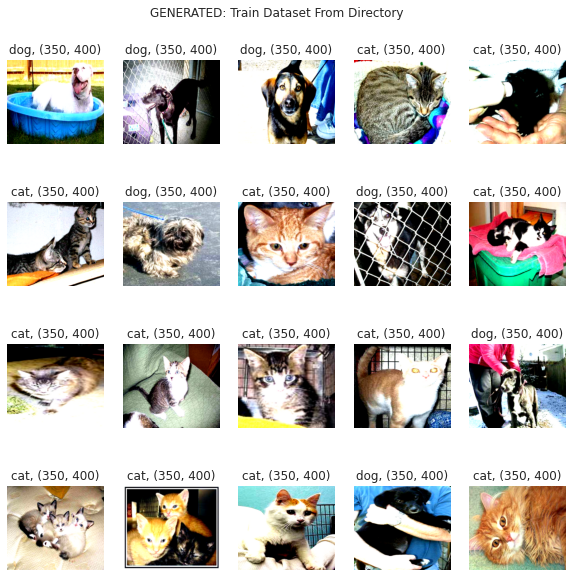

In [39]:
def show_batch(image_batch, label_batch=None):
    plt.figure(figsize=(10,10))    
    for n in range(20):
        ax = plt.subplot(4, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch is None:
            plt.title(f"test")
        else:            
            plt.title(f"{CLASS_NAMES[label_batch[n]]}, {image_batch[n].shape[:2]}")
        plt.axis('off')

image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch.numpy(), np.argmax(label_batch, axis=1))
plt.suptitle("GENERATED: Train Dataset From Directory", y=.93);

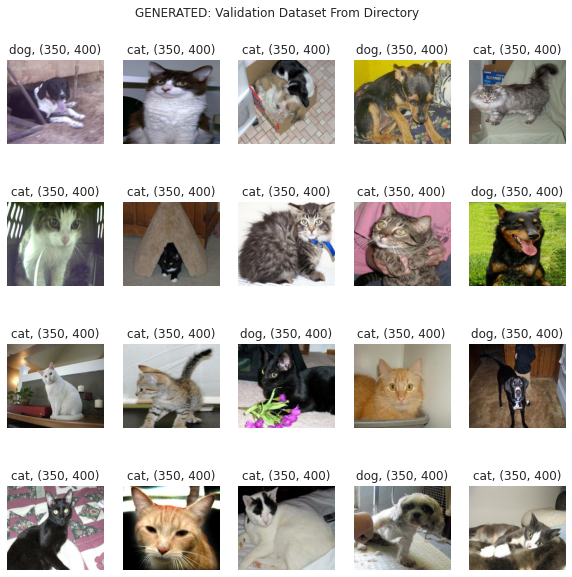

In [40]:
image_batch, label_batch = next(iter(val_dataset))
show_batch(image_batch.numpy(), np.argmax(label_batch, axis=1))
plt.suptitle("GENERATED: Validation Dataset From Directory", y=.93);

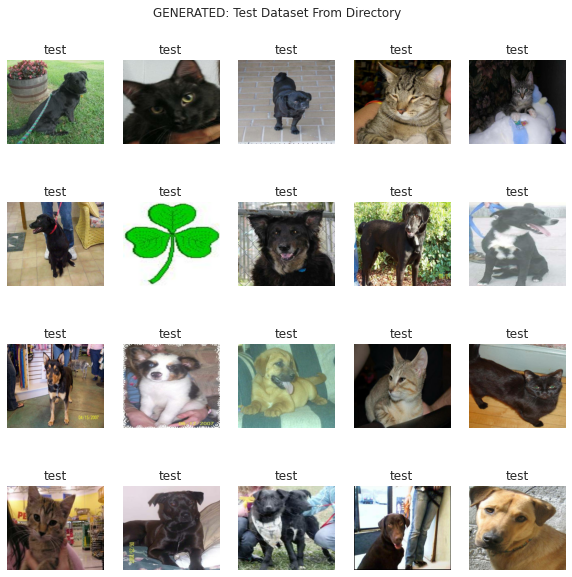

In [41]:
image_batch = next(iter(test_dataset))
show_batch(image_batch.numpy())
plt.suptitle("GENERATED: Test Dataset From Directory", y=.93);

### batch_size and steps_per_epoch

In [57]:
# find steps_per_epoch
np.ceil(total_train_file / BATCH_SIZE), np.ceil(total_val_file / BATCH_SIZE), np.ceil(total_test_file / BATCH_SIZE), 

(137.0, 18.0, 54.0)

In [58]:
np.ceil(total_train_file / BATCH_SIZE)*BATCH_SIZE, np.ceil(total_val_file / BATCH_SIZE)*BATCH_SIZE, np.ceil(total_test_file / BATCH_SIZE)*BATCH_SIZE, 

(17536.0, 2304.0, 6912.0)

### Dataset Define image and label

In [59]:
train_ds = train_dataset.map(lambda x, y: (x, y))
val_ds   = val_dataset.map(  lambda x, y: (x, y))
test_ds  = test_dataset.map( lambda    x: x)

print(train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, sep='\n')

(TensorSpec(shape=(None, 350, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.int16, name=None))
(TensorSpec(shape=(None, 350, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.int16, name=None))
TensorSpec(shape=(None, 350, 400, 3), dtype=tf.float32, name=None)


In [60]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label      : ", np.unique(np.argmax(label, axis=1), return_counts=True))

SAMPLE_TRAIN_LABEL = np.argmax(label, axis=1)
print(SAMPLE_TRAIN_LABEL)

Image shape:  (128, 350, 400, 3)
Label      :  (array([0, 1]), array([85, 43]))
[0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1]


In [61]:
from collections import Counter

counter = Counter(SAMPLE_TRAIN_LABEL)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
class_weights

{0: 1.0, 1: 1.9767441860465116}

In [62]:
from sklearn.utils import class_weight

class_weights = dict(
    zip(np.unique(SAMPLE_TRAIN_LABEL),
        class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(SAMPLE_TRAIN_LABEL), 
            y = SAMPLE_TRAIN_LABEL)
))
print(class_weights)

{0: 0.7529411764705882, 1: 1.4883720930232558}


In [63]:
from sklearn.utils import class_weight
sample_weight = class_weight.compute_sample_weight(class_weight='balanced', y=SAMPLE_TRAIN_LABEL)
np.unique(sample_weight)

array([0.75294118, 1.48837209])

### Dataset Shard Policy for kaggle GPU Warning

In [64]:
if gpus: 
    # Kaggle Warning -> Shard Policy for GPU
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    
    train_ds = train_ds.with_options(options)
    val_ds   = val_ds.with_options(options)
    test_ds  = test_ds.with_options(options)
    print('Apply Shard Policy for GPU')
else:
    print('Passed')

Apply Shard Policy for GPU


# Build the Model with Image FROM DIRECTORY (not work TPU)

In [65]:
print("Model Defined Shape: ", IMAGE_SHAPE)        # Input Layer Shape

# way-1
def build_classifier_model(
        input_shape: int = IMAGE_SHAPE,
        units:int        = 64,
) -> tf.keras.models.Model:    
    import tensorflow as tf    
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape, name='input'))   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform', activation='relu'))  
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)))   
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(filters=units, kernel_size=(3,3), kernel_initializer='he_uniform', activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.BatchNormalization()) 
    model.add(tf.keras.layers.Dense(units, activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(32, activation='relu'))   
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    precision_at_recall = tf.keras.metrics.PrecisionAtRecall(recall=0.8)
    f1_score            = tfa.metrics.F1Score(num_classes=2, threshold=0.5)
    fbeta_score         = tfa.metrics.FBetaScore(2, beta=2.0, reduction="mean")

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005), 
                  loss = 'categorical_crossentropy',  # 'binary_crossentropy', 
                  metrics = ['categorical_accuracy', 'Recall', f1_score, fbeta_score, precision_at_recall], 
                  # weighted_metrics = [tf.keras.metrics.Recall()] 
                  )
    return model

Model Defined Shape:  (350, 400, 3)


In [66]:
from sklearn.pipeline import Pipeline

tf.keras.backend.clear_session()

with strategy.scope():  
    model = build_classifier_model()
    display(model.summary())

    pipe_cnn1 = Pipeline([
        ("cnn", model)
    ])
    pipe_cnn1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               (None, 350, 400, 64)      3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 350, 400, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 175, 200, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 175, 200, 64)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 173, 198, 128)     73856     
_________________________________________________________________
average_pooling2d (AveragePo (None, 86, 99, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 86, 99, 128)       0

None

In [67]:
early_stop = EarlyStopping(monitor='val_loss', mode="min",
                           verbose = 1, patience = 9, restore_best_weights = True)

In [68]:
%%time
# history = pipe_cnn1.fit(train_data_gen, cnn__validation_data = val_data_gen, cnn__validation_steps=len(val_data_gen), #cnn__validation_split = 0.1, cnn__batch_size = 16, 
#                     cnn__epochs = 1000, cnn__steps_per_epoch=len(train_data_gen), cnn__verbose = 1, cnn__callbacks=[early_stop], cnn__class_weight=class_weights) # 

history = pipe_cnn1.fit(train_ds, cnn__validation_data = val_ds, cnn__validation_steps=np.ceil(total_val_file / BATCH_SIZE),  
                    cnn__epochs = 50, cnn__steps_per_epoch=np.ceil(total_train_file / BATCH_SIZE), cnn__verbose = 1, cnn__callbacks=[early_stop])  

Epoch 1/50


2023-01-08 21:59:16.856931: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-08 21:59:17.391841: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-08 21:59:29.184409: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_1_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-08 21:59:29.185180: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_1_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-08 21:59:29.672552: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_1_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The calle

137/137 [==============================] - ETA: 0s - loss: 3.0490 - categorical_accuracy: 0.6709 - recall: 0.6709 - f1_score: 0.5168 - fbeta_score: 0.5194 - precision_at_recall: 0.5779

2023-01-08 22:05:17.769980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 135 of 500
2023-01-08 22:05:27.792254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 470 of 500
2023-01-08 22:05:28.699547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 429s 3s/step - loss: 3.0490 - categorical_accuracy: 0.6709 - recall: 0.6709 - f1_score: 0.5168 - fbeta_score: 0.5194 - precision_at_recall: 0.5779 - val_loss: 0.7167 - val_categorical_accuracy: 0.5428 - val_recall: 0.5428 - val_f1_score: 0.4007 - val_fbeta_score: 0.4538 - val_precision_at_recall: 0.5241
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.5872 - categorical_accuracy: 0.7318 - recall: 0.7318 - f1_score: 0.5275 - fbeta_score: 0.5345 - precision_at_recall: 0.6648

2023-01-08 22:11:53.067358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 262 of 500
2023-01-08 22:12:00.410794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 389s 3s/step - loss: 0.5872 - categorical_accuracy: 0.7318 - recall: 0.7318 - f1_score: 0.5275 - fbeta_score: 0.5345 - precision_at_recall: 0.6648 - val_loss: 0.7750 - val_categorical_accuracy: 0.5397 - val_recall: 0.5397 - val_f1_score: 0.3718 - val_fbeta_score: 0.4393 - val_precision_at_recall: 0.5157
Epoch 3/50
137/137 [==============================] - ETA: 0s - loss: 0.5604 - categorical_accuracy: 0.7432 - recall: 0.7432 - f1_score: 0.5538 - fbeta_score: 0.5546 - precision_at_recall: 0.6817

2023-01-08 22:18:16.190558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 280 of 500
2023-01-08 22:18:22.707517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 390s 3s/step - loss: 0.5604 - categorical_accuracy: 0.7432 - recall: 0.7432 - f1_score: 0.5538 - fbeta_score: 0.5546 - precision_at_recall: 0.6817 - val_loss: 0.7289 - val_categorical_accuracy: 0.5598 - val_recall: 0.5598 - val_f1_score: 0.4141 - val_fbeta_score: 0.4676 - val_precision_at_recall: 0.5266
Epoch 4/50
137/137 [==============================] - ETA: 0s - loss: 0.5423 - categorical_accuracy: 0.7528 - recall: 0.7528 - f1_score: 0.5860 - fbeta_score: 0.5799 - precision_at_recall: 0.7125

2023-01-08 22:24:39.055222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 270 of 500
2023-01-08 22:24:46.722467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 382s 3s/step - loss: 0.5423 - categorical_accuracy: 0.7528 - recall: 0.7528 - f1_score: 0.5860 - fbeta_score: 0.5799 - precision_at_recall: 0.7125 - val_loss: 0.6725 - val_categorical_accuracy: 0.6017 - val_recall: 0.6017 - val_f1_score: 0.5120 - val_fbeta_score: 0.5352 - val_precision_at_recall: 0.5358
Epoch 5/50
137/137 [==============================] - ETA: 0s - loss: 0.5277 - categorical_accuracy: 0.7574 - recall: 0.7574 - f1_score: 0.6046 - fbeta_score: 0.5953 - precision_at_recall: 0.7285

2023-01-08 22:31:02.879611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 263 of 500
2023-01-08 22:31:10.211700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 385s 3s/step - loss: 0.5277 - categorical_accuracy: 0.7574 - recall: 0.7574 - f1_score: 0.6046 - fbeta_score: 0.5953 - precision_at_recall: 0.7285 - val_loss: 0.6753 - val_categorical_accuracy: 0.6066 - val_recall: 0.6066 - val_f1_score: 0.5314 - val_fbeta_score: 0.5486 - val_precision_at_recall: 0.5552
Epoch 6/50
137/137 [==============================] - ETA: 0s - loss: 0.5072 - categorical_accuracy: 0.7683 - recall: 0.7683 - f1_score: 0.6309 - fbeta_score: 0.6176 - precision_at_recall: 0.7482

2023-01-08 22:37:26.009253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 268 of 500
2023-01-08 22:37:33.074093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 383s 3s/step - loss: 0.5072 - categorical_accuracy: 0.7683 - recall: 0.7683 - f1_score: 0.6309 - fbeta_score: 0.6176 - precision_at_recall: 0.7482 - val_loss: 0.7336 - val_categorical_accuracy: 0.5721 - val_recall: 0.5721 - val_f1_score: 0.4467 - val_fbeta_score: 0.4886 - val_precision_at_recall: 0.5605
Epoch 7/50
137/137 [==============================] - ETA: 0s - loss: 0.4950 - categorical_accuracy: 0.7747 - recall: 0.7747 - f1_score: 0.6500 - fbeta_score: 0.6347 - precision_at_recall: 0.7597

2023-01-08 22:43:50.181006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 288 of 500
2023-01-08 22:43:56.752232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 382s 3s/step - loss: 0.4950 - categorical_accuracy: 0.7747 - recall: 0.7747 - f1_score: 0.6500 - fbeta_score: 0.6347 - precision_at_recall: 0.7597 - val_loss: 1.3383 - val_categorical_accuracy: 0.5943 - val_recall: 0.5943 - val_f1_score: 0.5875 - val_fbeta_score: 0.5928 - val_precision_at_recall: 0.5415
Epoch 8/50
137/137 [==============================] - ETA: 0s - loss: 0.4684 - categorical_accuracy: 0.7848 - recall: 0.7848 - f1_score: 0.6781 - fbeta_score: 0.6612 - precision_at_recall: 0.7736

2023-01-08 22:50:11.528987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 291 of 500
2023-01-08 22:50:18.120671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 379s 3s/step - loss: 0.4684 - categorical_accuracy: 0.7848 - recall: 0.7848 - f1_score: 0.6781 - fbeta_score: 0.6612 - precision_at_recall: 0.7736 - val_loss: 0.7035 - val_categorical_accuracy: 0.5664 - val_recall: 0.5664 - val_f1_score: 0.4360 - val_fbeta_score: 0.4810 - val_precision_at_recall: 0.5280
Epoch 9/50
137/137 [==============================] - ETA: 0s - loss: 0.4350 - categorical_accuracy: 0.7997 - recall: 0.7997 - f1_score: 0.7119 - fbeta_score: 0.6943 - precision_at_recall: 0.7990

2023-01-08 22:56:32.643363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 278 of 500
2023-01-08 22:56:39.347441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 383s 3s/step - loss: 0.4350 - categorical_accuracy: 0.7997 - recall: 0.7997 - f1_score: 0.7119 - fbeta_score: 0.6943 - precision_at_recall: 0.7990 - val_loss: 0.9076 - val_categorical_accuracy: 0.5629 - val_recall: 0.5629 - val_f1_score: 0.4271 - val_fbeta_score: 0.4751 - val_precision_at_recall: 0.5532
Epoch 10/50
137/137 [==============================] - ETA: 0s - loss: 0.4182 - categorical_accuracy: 0.8116 - recall: 0.8116 - f1_score: 0.7354 - fbeta_score: 0.7180 - precision_at_recall: 0.8176

2023-01-08 23:02:54.063574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 280 of 500
2023-01-08 23:03:00.450750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 382s 3s/step - loss: 0.4182 - categorical_accuracy: 0.8116 - recall: 0.8116 - f1_score: 0.7354 - fbeta_score: 0.7180 - precision_at_recall: 0.8176 - val_loss: 1.0402 - val_categorical_accuracy: 0.5633 - val_recall: 0.5633 - val_f1_score: 0.4201 - val_fbeta_score: 0.4719 - val_precision_at_recall: 0.5683
Epoch 11/50
137/137 [==============================] - ETA: 0s - loss: 0.3830 - categorical_accuracy: 0.8303 - recall: 0.8303 - f1_score: 0.7663 - fbeta_score: 0.7489 - precision_at_recall: 0.8439

2023-01-08 23:09:14.103604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 292 of 500
2023-01-08 23:09:20.580108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 381s 3s/step - loss: 0.3830 - categorical_accuracy: 0.8303 - recall: 0.8303 - f1_score: 0.7663 - fbeta_score: 0.7489 - precision_at_recall: 0.8439 - val_loss: 0.7721 - val_categorical_accuracy: 0.6236 - val_recall: 0.6236 - val_f1_score: 0.5465 - val_fbeta_score: 0.5630 - val_precision_at_recall: 0.6030
Epoch 12/50
137/137 [==============================] - ETA: 0s - loss: 0.3610 - categorical_accuracy: 0.8390 - recall: 0.8390 - f1_score: 0.7826 - fbeta_score: 0.7670 - precision_at_recall: 0.8625

2023-01-08 23:15:35.974933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 275 of 500
2023-01-08 23:15:42.784949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 382s 3s/step - loss: 0.3610 - categorical_accuracy: 0.8390 - recall: 0.8390 - f1_score: 0.7826 - fbeta_score: 0.7670 - precision_at_recall: 0.8625 - val_loss: 1.0885 - val_categorical_accuracy: 0.5747 - val_recall: 0.5747 - val_f1_score: 0.4553 - val_fbeta_score: 0.4941 - val_precision_at_recall: 0.5746
Epoch 13/50
137/137 [==============================] - ETA: 0s - loss: 0.3371 - categorical_accuracy: 0.8546 - recall: 0.8546 - f1_score: 0.8058 - fbeta_score: 0.7905 - precision_at_recall: 0.8824

2023-01-08 23:21:57.740166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 286 of 500
2023-01-08 23:22:04.376151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 381s 3s/step - loss: 0.3371 - categorical_accuracy: 0.8546 - recall: 0.8546 - f1_score: 0.8058 - fbeta_score: 0.7905 - precision_at_recall: 0.8824 - val_loss: 0.6437 - val_categorical_accuracy: 0.6528 - val_recall: 0.6528 - val_f1_score: 0.6174 - val_fbeta_score: 0.6200 - val_precision_at_recall: 0.6114
Epoch 14/50
137/137 [==============================] - ETA: 0s - loss: 0.3117 - categorical_accuracy: 0.8687 - recall: 0.8687 - f1_score: 0.8279 - fbeta_score: 0.8148 - precision_at_recall: 0.9057

2023-01-08 23:28:17.202556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 291 of 500
2023-01-08 23:28:24.041777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 377s 3s/step - loss: 0.3117 - categorical_accuracy: 0.8687 - recall: 0.8687 - f1_score: 0.8279 - fbeta_score: 0.8148 - precision_at_recall: 0.9057 - val_loss: 0.8076 - val_categorical_accuracy: 0.6079 - val_recall: 0.6079 - val_f1_score: 0.5259 - val_fbeta_score: 0.5456 - val_precision_at_recall: 0.5733
Epoch 15/50
137/137 [==============================] - ETA: 0s - loss: 0.2932 - categorical_accuracy: 0.8708 - recall: 0.8708 - f1_score: 0.8319 - fbeta_score: 0.8199 - precision_at_recall: 0.9138

2023-01-08 23:34:36.017468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 273 of 500
2023-01-08 23:34:43.033469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 381s 3s/step - loss: 0.2932 - categorical_accuracy: 0.8708 - recall: 0.8708 - f1_score: 0.8319 - fbeta_score: 0.8199 - precision_at_recall: 0.9138 - val_loss: 0.7724 - val_categorical_accuracy: 0.6240 - val_recall: 0.6240 - val_f1_score: 0.5704 - val_fbeta_score: 0.5792 - val_precision_at_recall: 0.5830
Epoch 16/50
137/137 [==============================] - ETA: 0s - loss: 0.2542 - categorical_accuracy: 0.8932 - recall: 0.8932 - f1_score: 0.8633 - fbeta_score: 0.8533 - precision_at_recall: 0.9434

2023-01-08 23:40:56.420461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 289 of 500
2023-01-08 23:41:03.248375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 380s 3s/step - loss: 0.2542 - categorical_accuracy: 0.8932 - recall: 0.8932 - f1_score: 0.8633 - fbeta_score: 0.8533 - precision_at_recall: 0.9434 - val_loss: 1.0123 - val_categorical_accuracy: 0.6170 - val_recall: 0.6170 - val_f1_score: 0.5392 - val_fbeta_score: 0.5565 - val_precision_at_recall: 0.5884
Epoch 17/50
137/137 [==============================] - ETA: 0s - loss: 0.2347 - categorical_accuracy: 0.9057 - recall: 0.9057 - f1_score: 0.8804 - fbeta_score: 0.8721 - precision_at_recall: 0.9544

2023-01-08 23:47:15.692102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 278 of 500
2023-01-08 23:47:22.563450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 382s 3s/step - loss: 0.2347 - categorical_accuracy: 0.9057 - recall: 0.9057 - f1_score: 0.8804 - fbeta_score: 0.8721 - precision_at_recall: 0.9544 - val_loss: 1.4913 - val_categorical_accuracy: 0.5991 - val_recall: 0.5991 - val_f1_score: 0.5247 - val_fbeta_score: 0.5422 - val_precision_at_recall: 0.5760
Epoch 18/50
137/137 [==============================] - ETA: 0s - loss: 0.2064 - categorical_accuracy: 0.9177 - recall: 0.9177 - f1_score: 0.8960 - fbeta_score: 0.8882 - precision_at_recall: 0.9667

2023-01-08 23:53:37.444354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 278 of 500
2023-01-08 23:53:44.362938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 381s 3s/step - loss: 0.2064 - categorical_accuracy: 0.9177 - recall: 0.9177 - f1_score: 0.8960 - fbeta_score: 0.8882 - precision_at_recall: 0.9667 - val_loss: 0.8252 - val_categorical_accuracy: 0.6415 - val_recall: 0.6415 - val_f1_score: 0.5853 - val_fbeta_score: 0.5935 - val_precision_at_recall: 0.5983
Epoch 19/50
137/137 [==============================] - ETA: 0s - loss: 0.1895 - categorical_accuracy: 0.9261 - recall: 0.9261 - f1_score: 0.9071 - fbeta_score: 0.9003 - precision_at_recall: 0.9738

2023-01-08 23:59:58.852454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 278 of 500
2023-01-09 00:00:05.627105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 380s 3s/step - loss: 0.1895 - categorical_accuracy: 0.9261 - recall: 0.9261 - f1_score: 0.9071 - fbeta_score: 0.9003 - precision_at_recall: 0.9738 - val_loss: 0.8992 - val_categorical_accuracy: 0.6410 - val_recall: 0.6410 - val_f1_score: 0.5818 - val_fbeta_score: 0.5910 - val_precision_at_recall: 0.6256
Epoch 20/50
137/137 [==============================] - ETA: 0s - loss: 0.1717 - categorical_accuracy: 0.9322 - recall: 0.9322 - f1_score: 0.9152 - fbeta_score: 0.9096 - precision_at_recall: 0.9787

2023-01-09 00:06:17.472738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 285 of 500
2023-01-09 00:06:23.929110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 377s 3s/step - loss: 0.1717 - categorical_accuracy: 0.9322 - recall: 0.9322 - f1_score: 0.9152 - fbeta_score: 0.9096 - precision_at_recall: 0.9787 - val_loss: 1.0639 - val_categorical_accuracy: 0.6467 - val_recall: 0.6467 - val_f1_score: 0.5952 - val_fbeta_score: 0.6018 - val_precision_at_recall: 0.6090
Epoch 21/50
137/137 [==============================] - ETA: 0s - loss: 0.1587 - categorical_accuracy: 0.9385 - recall: 0.9385 - f1_score: 0.9232 - fbeta_score: 0.9176 - precision_at_recall: 0.9828

2023-01-09 00:12:37.885939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 276 of 500
2023-01-09 00:12:44.821214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 381s 3s/step - loss: 0.1587 - categorical_accuracy: 0.9385 - recall: 0.9385 - f1_score: 0.9232 - fbeta_score: 0.9176 - precision_at_recall: 0.9828 - val_loss: 1.1345 - val_categorical_accuracy: 0.6140 - val_recall: 0.6140 - val_f1_score: 0.5296 - val_fbeta_score: 0.5496 - val_precision_at_recall: 0.5889
Epoch 22/50
137/137 [==============================] - ETA: 0s - loss: 0.1156 - categorical_accuracy: 0.9573 - recall: 0.9573 - f1_score: 0.9472 - fbeta_score: 0.9439 - precision_at_recall: 0.9926

2023-01-09 00:18:58.306640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 270 of 500
2023-01-09 00:19:05.252591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


137/137 [==============================] - 383s 3s/step - loss: 0.1156 - categorical_accuracy: 0.9573 - recall: 0.9573 - f1_score: 0.9472 - fbeta_score: 0.9439 - precision_at_recall: 0.9926 - val_loss: 1.4711 - val_categorical_accuracy: 0.5856 - val_recall: 0.5856 - val_f1_score: 0.4712 - val_fbeta_score: 0.5066 - val_precision_at_recall: 0.5751
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
CPU times: user 2h 43min 42s, sys: 25min 19s, total: 3h 9min 1s
Wall time: 2h 20min 51s


137/137 [==============================] - 381s 3s/step - loss: 0.3371 - categorical_accuracy: 0.8546 - recall: 0.8546 - f1_score: 0.8058 - fbeta_score: 0.7905 - precision_at_recall: 0.8824 - val_loss: 0.6437 - val_categorical_accuracy: 0.6528 - val_recall: 0.6528 - val_f1_score: 0.6174 - val_fbeta_score: 0.6200 - val_precision_at_recall: 0.6114

In [2]:
# save model permanently and check
# model.save_weights('first_try.h5')
pipe_cnn1[-1].save('./content/drive/MyDrive/cat_dog_data1.h5')

In [ ]:
history[-1].metrics_names

In [ ]:
history_df = pd.DataFrame(history[-1].history.history)
history_df.index += 1
history_df.tail(5)

In [ ]:
# Plot training results
plot_history(history)

In [ ]:
plot_metrics(pipe_cnn1, pipe_cnn1[-1].metrics_names, pipe=True)

## Test Data Precision and Accuracy Label 

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve #, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  SCORERS, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/cat_dog_data1.h5')

In [ ]:
# predict probabilities 
y_pred_prob_val  = model1.predict(val_data_gen, verbose=0)
y_pred_prob_train = model1.predict(train_data_gen, verbose=0)

y_pred_prob_val.shape, y_pred_prob_train.shape

In [ ]:
# predict crisp classes 
y_pred_val   = np.argmax(y_pred_prob_val, axis=1) 
y_pred_train = np.argmax(y_pred_prob_train, axis=1)  

y_pred_val.shape, y_pred_train.shape

In [ ]:
print(confusion_matrix(val_data_gen.classes, y_pred_val))
print(classification_report(val_data_gen.classes, y_pred_val))

In [ ]:
print(confusion_matrix(train_data_gen.classes, y_pred_train))
print(classification_report(train_data_gen.classes, y_pred_train))

In [ ]:
(val_data_gen.classes != y_pred_val).sum()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    val_data_gen.classes, y_pred_val,
    # labels=classes
)

cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=CLASS_NAMES
)

fig, ax = plt.subplots(figsize=(5, 5))

# Deactivate default colorbar
cmp.plot(ax=ax, colorbar=False)
plt.grid(False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+.01, ax.get_position().y0, .033, ax.get_position().height])
plt.colorbar(cmp.im_, cax=cax)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_data_gen.classes, y_pred_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_data_gen.classes, y_pred_val, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_data_gen.classes, y_pred_val, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(val_data_gen.classes, y_pred_val, average='weighted')
print('F1 score: %f' % f1)

In [ ]:
# kappa
kappa = cohen_kappa_score(val_data_gen.classes, y_pred_val)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(val_data_gen.classes, y_pred_prob_val[:, 0])
print('ROC AUC: %f' % auc)
auc = roc_auc_score(val_data_gen.classes, y_pred_prob_val[:, 1])
print('ROC AUC: %f' % auc)

# Prediction

In [ ]:
# View a random image
import random

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/cat_dog_data1.h5')

In [ ]:
target_class = random.choice(CLASS_NAMES)
target_class

In [ ]:
random_image = random.sample(os.listdir(test_path), 1)
random_image

In [ ]:
# image_path = 'cat-dog.jpg'
image_path = test_path +"/"+ random_image[0]
image_path

In [ ]:
my_image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SHAPE)
my_image

In [ ]:
my_image = tf.keras.preprocessing.image.img_to_array(my_image)
my_image.shape

In [ ]:
my_image = np.expand_dims(my_image, axis=0)
my_image.shape

In [ ]:
np.argmax(model.predict(my_image)) 

# End of the Project